# CWatM output data

![Screenshot 2024-11-07 at 14.22.42.png](<attachment:Screenshot 2024-11-07 at 14.22.42.png>)
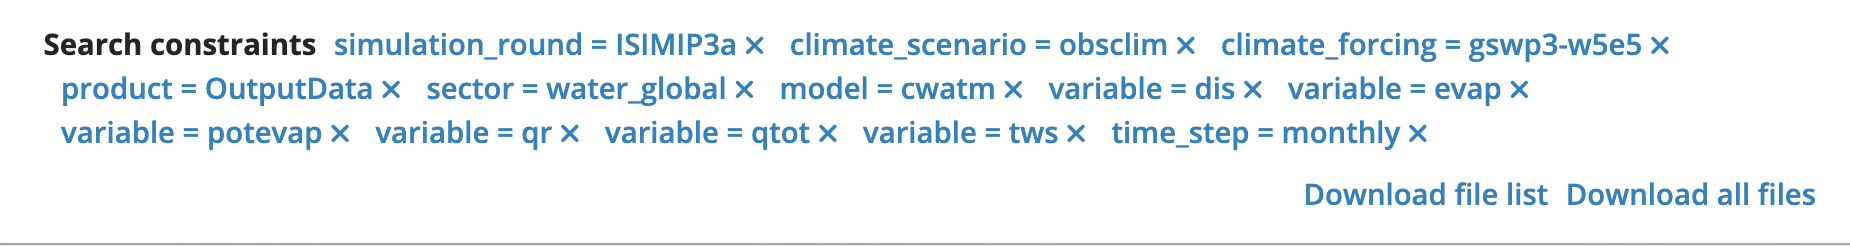

In [ ]:
from pathlib import Path
from functools import reduce
import pandas as pd
import xarray as xr
from datetime import datetime as dt

from isimip_client.client import ISIMIPClient

In [ ]:
RAW_CWATM_OUTPUT_FOLDER = Path("../data/raw/CWatM_output")

## Define function

In [ ]:
def download_process_merge_ISIMIP_output(variable,
                                         flux_conversion_factor=None,
                                         averaging_time=None):

    client = ISIMIPClient()

    # Search the ISIMIP repository using specifiers.
    # Max's TIP: in data.isimip.org, use the "Facets" "Sidebar view" to ge the specifiers key and values
    response = client.files(simulation_round="ISIMIP3a",
                            product="OutputData",
                            sector="water_global",
                            model="cwatm",
                            climate_scenario="obsclim",
                            time_step="monthly",
                            climate_forcing="gswp3-w5e5",
                            variable=variable
                            )

    # Download files
    for result in response["results"]:

        file_name = result["name"]
        if "monthly" in file_name:

            print(f"Downloading file {file_name}")
            # Download file
            client.download(result["file_url"], path=RAW_CWATM_OUTPUT_FOLDER.joinpath(variable))

        else:
            print(f"Skipping {file_name} due to none matching years")

    ## Process and merge files
    files = RAW_CWATM_OUTPUT_FOLDER.joinpath(variable).glob("cwatm_gswp3-w5e5*.nc")

    data_sum_list = []
    time_slice = slice(dt(1975, 1, 1), dt(2004, 12, 31))

    for file in files:

        print(f"Processing file {file.name}")

        data = xr.open_dataset(file)
        data_sliced = data.sel(time=time_slice)
        if flux_conversion_factor is not None:
            data_sliced = data_sliced * flux_conversion_factor
        data_sum = data_sliced.sum("time")

        data_sum_list.append(data_sum)

    print("Merging files")
    data_sum = reduce(lambda x, y: x + y, data_sum_list)

    if averaging_time == "day":
        time_slice_days = len(pd.date_range(start=dt(1975, 1, 1), end=dt(2004, 12, 31), freq="d"))
        data_mean = data_sum / time_slice_days

        print("Storing 'mean_1975_2004.nc' file")
        data_mean.to_netcdf(RAW_CWATM_OUTPUT_FOLDER.joinpath(variable, "mean_1975_2004.nc"))
    elif averaging_time == "year":
        time_slice_years = len(pd.date_range(start=dt(1975, 1, 1), end=dt(2004, 12, 31), freq="YE"))
        data_mean = data_sum / time_slice_years

        print("Storing 'mean_1975_2004.nc' file")
        data_mean.to_netcdf(RAW_CWATM_OUTPUT_FOLDER.joinpath(variable, "mean_1975_2004.nc"))
    else:
        print("Storing 'sum_1975_2004.nc' file")
        data_sum.to_netcdf(RAW_CWATM_OUTPUT_FOLDER.joinpath(variable, "sum_1975_2004.nc"))

## Evapotranspiration

In [ ]:
VARIABLE = "evap"

download_process_merge_ISIMIP_output(VARIABLE,
                                     flux_conversion_factor=86400*30, # Convert from kg/m²/s to mm/month
                                     averaging_time="year"
                                     )

## Potential Evapotranspiration

In [ ]:
VARIABLE = "potevap"

download_process_merge_ISIMIP_output(VARIABLE,
                                     flux_conversion_factor=86400*30, # Convert from kg/m²/s to mm/month
                                     averaging_time="year"
                                     )

## Total groundwater recharge

In [ ]:
VARIABLE = "qr"

download_process_merge_ISIMIP_output(VARIABLE,
                                     flux_conversion_factor=86400*30, # Convert from kg/m²/s to mm/month
                                     averaging_time="year"
                                     )

## Total Runoff

In [ ]:
VARIABLE = "qtot"

download_process_merge_ISIMIP_output(VARIABLE,
                                     flux_conversion_factor=86400*30, # Convert from kg/m²/s to mm/month
                                     averaging_time="year"
                                     )

## Discharge

In [ ]:
VARIABLE = "dis"

download_process_merge_ISIMIP_output(VARIABLE,
                                     flux_conversion_factor=None,  #86400*30, # Convert from kg/m²/s to mm/month
                                     averaging_time="year"
                                     )

## Total Water Storage

In [ ]:
VARIABLE = "tws"

download_process_merge_ISIMIP_output(VARIABLE,
                                     flux_conversion_factor=None,
                                     averaging_time="year"
                                     )

# Merge outputs

In [ ]:
evap_mean = xr.open_dataset(RAW_CWATM_OUTPUT_FOLDER.joinpath("evap", "mean_1975_2004.nc"))
potevap_mean = xr.open_dataset(RAW_CWATM_OUTPUT_FOLDER.joinpath("potevap", "mean_1975_2004.nc"))
qr_mean = xr.open_dataset(RAW_CWATM_OUTPUT_FOLDER.joinpath("qr", "mean_1975_2004.nc"))
qtot_mean = xr.open_dataset(RAW_CWATM_OUTPUT_FOLDER.joinpath("qtot", "mean_1975_2004.nc"))
tws_mean = xr.open_dataset(RAW_CWATM_OUTPUT_FOLDER.joinpath("tws", "mean_1975_2004.nc"))

data_mean = xr.merge([evap_mean,
                      potevap_mean,
                      qr_mean,
                      qtot_mean,
                      tws_mean])

data_mean.to_netcdf(Path("../data/processed/CWatM_data/outputs.nc"))